<a href="https://colab.research.google.com/github/zhuyuan7/nlp_test/blob/main/%EC%BC%80%EA%B8%800407.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy


     |████████████████████████████████| 19.4MB 60.6MB/s 
     |████████████████████████████████| 460kB 53.5MB/s 
     |████████████████████████████████| 92kB 13.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import json
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding,Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from collections import Counter
from keras import optimizers

DATA_IN_PATH ='./content/drive/MyDrive/케글/DATA_IN/'

In [3]:
train = pd.read_csv(r'/content/drive/MyDrive/케글/train.hate.csv', engine='python', encoding='utf-8', sep=',')
dev = pd.read_csv(r'/content/drive/MyDrive/케글/dev.hate.csv', engine='python', encoding='utf-8', sep=',')
test_data = pd.read_csv(r'/content/drive/MyDrive/케글/test.hate.no_label.csv', engine='python', encoding='utf-8', sep=',')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7896 entries, 0 to 7895
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  7896 non-null   object
 1   label     7896 non-null   object
dtypes: object(2)
memory usage: 123.5+ KB


In [5]:
dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  471 non-null    object
 1   label     471 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  974 non-null    object
dtypes: object(1)
memory usage: 7.7+ KB


In [7]:
train_dev=pd.concat([train,dev])

In [8]:
train_dev

,comments,label
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,hate
...,...,...
466,지현우 범죄 저지르지 않았나요?,offensive
467,여자인생 망칠 일 있나 ㅋㅋ,hate
468,근데 전라도에서 사고가 났는데 굳이 서울까지 와서 병원에 가느 이유는?,offensive
469,"할매젖x, 뱃살x, 몸매 s라인, 유륜은 적당해야됨(너무크거나 너무 작아도 x), ...",hate


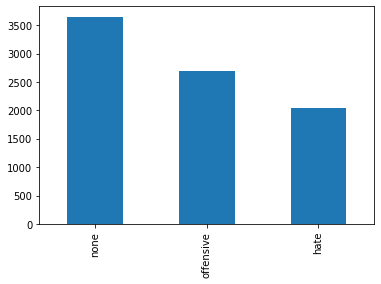

In [9]:
train_dev['label'].value_counts().plot(kind='bar')

In [10]:
print(train_dev.groupby('label').size().reset_index(name='count'))

       label  count
0       hate   2033
1       none   3646
2  offensive   2688


In [11]:
train_dev=train_dev.replace({"none":0,"offensive":1,"hate":2})
train_dev

,comments,label
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,2
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",2
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",0
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,2
...,...,...
466,지현우 범죄 저지르지 않았나요?,1
467,여자인생 망칠 일 있나 ㅋㅋ,2
468,근데 전라도에서 사고가 났는데 굳이 서울까지 와서 병원에 가느 이유는?,1
469,"할매젖x, 뱃살x, 몸매 s라인, 유륜은 적당해야됨(너무크거나 너무 작아도 x), ...",2


In [12]:
train_dev['comments'][:5]

0    (현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...
1    ....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...
2    ...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...
3                   1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데
4    1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...
Name: comments, dtype: object

In [13]:
review_text= train_dev['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
print(review_text)

0        현재 호텔주인 심정 아 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네
1        한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ
2      못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...
3                           화 어설펐는데 화 지나서부터는 갈수록 너무 재밌던데
4           사람 얼굴 손톱으로 긁은것은 인격살해이고 동영상이 몰카냐 메걸리안들 생각이 없노
                             ...                        
466                                     지현우 범죄 저지르지 않았나요
467                                      여자인생 망칠 일 있나 ㅋㅋ
468               근데 전라도에서 사고가 났는데 굳이 서울까지 와서 병원에 가느 이유는
469       할매젖 뱃살 몸매 라인 유륜은 적당해야됨너무크거나 너무 작아도  엉덩이가 빵빵해야됨
470    남자가 잘못한거라면 반성도 없다면나였다면  여자처럼 아주 못되게 할것같다왜 나를 배...
Name: comments, Length: 8367, dtype: object


In [14]:
def preprocessing(review, okt, remove_stopwords = False, stop_words =[]):
#review: 전처리할 텍스트
#remove_stopword:불용어를 제거할 지 여부 선택. 기본은 False
#stop_word: 불용어 사전은 사용자가 직접 입력해야함. 기본값은 빈 리스트

# 1. 한글 및 공백을 제외한 문자를 모두 제거
 # review_text = train_dev['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",review)
  review_text = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",review)

#2. okt객체를 활용해 형태소 단위로 나눈다.
  word_review = okt.morphs(review_text, stem=True)

  if remove_stopwords:
  #불용어 제거 (선택적)
    word_review = [token for token in word_review if not token in stop_words]

  return word_review


stop_words = ['ㅠ', 'ㅋ' '을', '를', '수', '주','되', '의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()
clean_train_review =[]

for review in train_dev ['comments']:
  # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
  if type(review) == str:
    clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words =stop_words))
  else:
    clean_train_review.append([]) # str이 아니면 비어있는 값 추가

clean_train_review[:4]

[['현재',
  '호텔',
  '주인',
  '심정',
  '아',
  '난',
  '마른하늘',
  '날벼락',
  '맞다',
  '호텔',
  '망하다',
  '생기다',
  '누',
  '군',
  '계속',
  '추모',
  '받다'],
 ['한국',
  '적',
  '인',
  '미인',
  '대표',
  '적',
  '인',
  '분',
  '너무나',
  '곱',
  '고',
  '아름답다',
  '모습',
  '그',
  '모습',
  '뒤',
  '슬픔',
  '을',
  '미처',
  '알다'],
 ['못',
  '되다',
  '넘다',
  '들다',
  '남',
  '고통',
  '을',
  '즐기다',
  '넘다',
  '들이다',
  '젠',
  '마땅하다',
  '처벌',
  '을',
  '받다',
  '그',
  '래야',
  '공정하다',
  '사회',
  '지',
  '심다',
  '거두다'],
 ['화', '어설프다', '화', '지나다', '갈수록', '너무', '재밌다']]

In [15]:
clean_test_review = []

for review in test_data['comments']:
  #빈 데이터에서 멈추지 않도록 문자열인 경우에만 진행
  if type(review) == str:
    clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words =stop_words))
  else:
    clean_train_review.append([]) # str이 아니면 비어있는 값 추가

In [16]:
# 테스트 데이터 'label' 컬럼 만들기
test_data = test_data.reindex(columns = test_data.columns.tolist() + ["label"])

In [17]:
test_data.shape
test_data.columns

Index(['comments', 'label'], dtype='object')

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index # 단어 사전 형태

MAX_SEQUENCE_LENGTH = 52

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
# 학습데이터를 벡터화
train_labels = np.array(train_dev['label']) # 학습 데이터의 라벨
test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
# 평가 데이터를 벡터화
test_labels = np.array(test_data['label']) # 평가 데이터의 라벨

In [35]:
X = np.expand_dims(train_inputs, axis = 0)
print('Shape of X is ', X.shape)

Shape of X is  (1, 9341, 52)


In [40]:
y = np.array([1,0,1])
y = y.reshape(1,-1)
y = np.expand_dims(test_inputs, axis = 0)
print('Shape of y is ', Y.shape)

Shape of y is  (1, 0, 52)


In [19]:
DATA_IN_PATH ='/content/drive/MyDrive/케글/DATA_IN/'
DEFAULT_PATH ='/content/drive/MyDrive/케글/DEFAULT_PATH/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs ={}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)+1 # vocab size 추가

# 저장하는 디렉터리가 존재하지 않으면 생성
if not os.path.exists(DEFAULT_PATH + DATA_IN_PATH):
  os.makedirs(DEFAULT_PATH + DATA_IN_PATH)

# 전처리된 학습 데이터를 넘파이 형태로 저장
np.save(open(DEFAULT_PATH + DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DEFAULT_PATH + DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)

# 전처리된 평가 데이터를 넘파이 형태로 저장
np.save(open(DEFAULT_PATH + DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DEFAULT_PATH + DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DEFAULT_PATH + DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)

# 모델링

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

In [21]:
train_input = np.load(open('/content/drive/MyDrive/케글/DATA_IN/nsmc_train_input.npy', 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open('/content/drive/MyDrive/케글/DATA_IN/nsmc_train_label.npy','rb'))
prepro_configs = json.load(open('/content/drive/MyDrive/케글/DATA_IN/data_configs.json','r'))

# 파라미터 정의

In [22]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS =2
VALID_SPLIT =0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'embedding_size':18,
         'num_filters':100,
         'dropout_rate':0.5,
         'hidden_dimension':250,
         'output_dimensition':1}

# 모델 구현 함수

In [23]:
class CNNClassifier(tf.keras.Model):

  def __init__(self,**kargs):
    super(CNNClassifier, self).__init__(name=kargs['model_name'])
    self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                      output_dim=kargs['embedding_size'])
    self.conv_list =[layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                   for kernel_size in [3,4,5]]
    self.pooling = layers.GlobalMaxPooling1D()
    self.dropout = layers.Dropout(kargs['dropout_rate'])
    self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                            activation=tf.keras.activations.relu,
                            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    self.fc2 = layers.Dense(units=kargs['output_dimensition'],
                            activation=tf.keras.activations.softmax,
                            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        

  def call(self, x):
    x = self.embedding(x)
    x = self.dropout(x)
    x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
    x = self.fc1(x)
    x = self.fc2(x)

    return x

# 모델 학습

In [33]:
X_test = tf.keras.utils.normalize(x_test, axis = 1)

NameError: ignored

In [32]:
model = CNNClassifier(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # 다중 분류 손실함수 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])



In [31]:
DATA_OUT_PATH ='/content/drive/MyDrive/케글/DATA_OUT/'

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + model_name +'/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists

if os.path.exists(checkpoint_dir):
  print("{} -- Folder already exiists \n".format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)
  print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True,
    save_weights_only=True)

history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

/content/drive/MyDrive/케글/DATA_OUT/cnn_classifier_kr -- Folder already exiists 



ValueError: ignored